Importing Libraries

In [95]:

import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Define the constants and initial conditions

In [105]:
# Parameters
alpha = 0.5  # Thermal diffusivity
length = 1.0  # Length of the rod
time_end = 1  # End time
num_points = 30  # Number of spatial points
num_steps = 1000  # Number of time steps
L_fusion = 3.98e5
# Material properties
rho = 2700  # Density of aluminum (kg/m^3)
cp = 900  # Specific heat of aluminum (J/kg-K)

Defining the simulation field and initilisation of the temperatures

In [112]:
# Spatial and time step sizes
dx = length / (num_points - 1)
dt = time_end / num_steps

# Initial condition
initial_temperature = np.full(num_points, 700) # Initial temperature of 700 at all the places
#initial_phi = np.zeros(num_points) # Initital phase
# Set one end at 25 degrees and the other end at 600 degrees
#initial_temperature[0:-1] = 100.0  # Set the first to second last element (one end) to 100 degrees

initial_temperature[-1] = 40  # Set the last element (other end) to 40 degrees



# Initialize temperature array
temperature = initial_temperature.copy()
print(np.shape(temperature))
# phi = initial_phi.copy()
# Store temperature at each time step
time_steps = np.linspace(0, time_end, num_steps + 1)
print(np.shape(time_steps))
#print(time_steps)
temperature_history = [temperature.copy()]
print(np.shape(temperature_history))
#phi_history = [phi.copy()]

(30,)
(1001,)
(1, 30)


Solving the heat transfer equation and phase change using numerical methods

In [115]:
# Finite difference method
for n in range(1, num_steps + 1):
    # Compute new temperature values using finite difference
    temperature[1:-1] = ( temperature[1:-1] + alpha * dt / dx**2 * (temperature[2:] - 2 * temperature[1:-1] + temperature[:-2])  )
    
    #phi[1:-1] =(phi[1:-1]+ dt*L_fusion*temperature[1:-1]/(rho*c))
    # Store the temperature at this time step
    temperature_history.append(temperature.copy())
    #phi_history.append(phi.copy)

print(np.shape(temperature_history))

(2001, 30)


Plotting the solutions

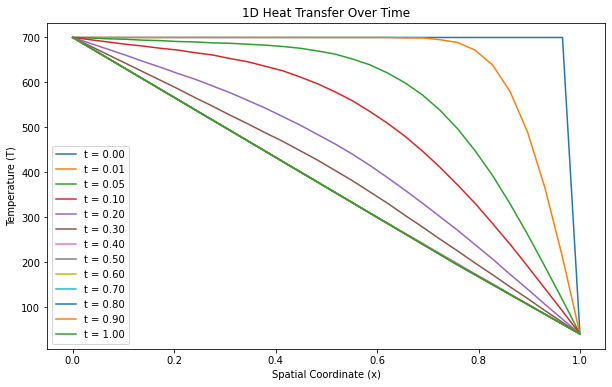

In [122]:
plot_points = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Plot the results
plt.figure(figsize=(10, 6))
# Plot spatial variation at different time steps
for i in plot_points:
    plt.plot(np.linspace(0, length, num_points), temperature_history[i], label=f"t = {time_steps[i]:.2f}")

plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Temperature (T)')
plt.title('1D Heat Transfer Over Time')
plt.legend()
plt.show()

In [ ]:
# Save data to CSV file
csv_filename = 'heat_transfer_data_with_time.csv'

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Spatial Coordinate (x)', *time_steps])
    csv_writer.writerows(np.column_stack((np.linspace(0, length, num_points), *temperature_history)))

print(f'Data saved to {csv_filename}')

Data saved to heat_transfer_data_with_time.csv


Machine Learning of the solidification 

Support Vector Regression is employed to train the model to predict the temperature
Data preparation

Extract the features and the target data

In [ ]:
raw_data =  pd.read_csv('heat_transfer_data_with_time.csv') #Read the data
#print(raw_data.head)

X1 = raw_data['Spatial Coordinate (x)'].values # Get the spatial coordinate values
print(len(X1))
X2 = np.arange(0,time_end +dt,dt) # Get the time values
print(len(X2))
#y = np.zeros(len(X1)*len(X2))
#print(len(y))

y_data = raw_data.iloc[0:,1:].values.ravel()    # Get the temperature values
#y = y_data.flatten()
print(y_data)


ftr = list(itertools.product(X1,X2)) #  Get the spatial and time coordinate values
feature = np.array(ftr) # Convert to numpy array

X_train, X_test, y_train, y_test = train_test_split(feature, y_data, test_size=0.2, random_state=42)




30
1001
[100. 100. 100. ... 600. 600. 600.]


Training of SVR

In [ ]:
svr_rbf = svm.SVR(kernel="rbf", C=2000, gamma=100, epsilon=0.1)  # epsilon is the margin of deviation from the regression curve

svr_rbf.fit(X_train, y_train)




RMSE: 3.107459
RMSE2: 5.360803


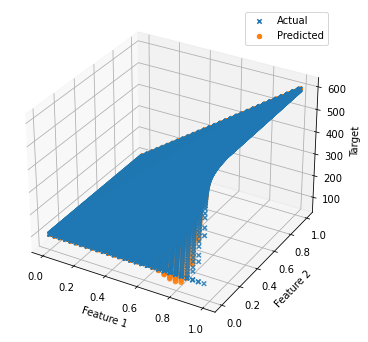

In [ ]:
y_pred = svr_rbf.predict(feature)
rmse = np.sqrt(mean_squared_error(y_data, y_pred))

y_pred2 = svr_rbf.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
print("RMSE: %f" % (rmse))
print("RMSE2: %f" % (rmse2))
# Visualization (for 2D data)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(feature[:, 0], feature[:, 1], y_data, label='Actual', marker='x')
ax.scatter(feature[:, 0], feature[:, 1], y_pred, label='Predicted', marker='o')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')
ax.legend()

plt.show()



PINN training